In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)

In [2]:
# Load the data
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [3]:
index = test_data['index']
test_data = test_data.drop('index', axis=1)

In [4]:
print("This is the train data shape: ", train_data.shape)
print("This is the test data shape: ", test_data.shape)

This is the train data shape:  (26206, 19)
This is the test data shape:  (11232, 18)


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26206 entries, 0 to 26205
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   created_at                    26206 non-null  object 
 1   default_profile               26206 non-null  bool   
 2   default_profile_image         26206 non-null  bool   
 3   description                   21115 non-null  object 
 4   favourites_count              26206 non-null  int64  
 5   followers_count               26206 non-null  int64  
 6   friends_count                 26206 non-null  int64  
 7   geo_enabled                   26206 non-null  bool   
 8   id                            26206 non-null  int64  
 9   lang                          20618 non-null  object 
 10  location                      26204 non-null  object 
 11  profile_background_image_url  22971 non-null  object 
 12  profile_image_url             26205 non-null  object 
 13  s

In [6]:
train_data.describe()

,favourites_count,followers_count,friends_count,id,statuses_count,average_tweets_per_day,account_age_days,target
count,26206.000000,2.620600e+04,2.620600e+04,2.620600e+04,2.620600e+04,26206.000000,26206.000000,26206.000000
mean,12159.971342,3.732983e+05,4.427275e+03,1.253306e+17,2.072485e+04,6.754636,3017.870831,0.335152
std,33628.948536,2.515996e+06,4.602204e+04,3.035728e+17,6.345569e+04,22.782745,1018.958572,0.472053
min,0.000000,0.000000e+00,0.000000e+00,5.860000e+02,0.000000e+00,0.000000,483.000000,0.000000
25%,347.000000,3.400000e+01,3.400000e+01,9.799366e+07,1.331000e+03,0.486250,2302.000000,0.000000
50%,2037.000000,3.540000e+02,2.920000e+02,3.997210e+08,4.143500e+03,1.464000,3218.000000,0.000000
75%,8751.750000,8.241500e+03,8.780000e+02,2.480241e+09,1.679150e+04,5.460000,3895.000000,1.000000
max,839929.000000,1.216415e+08,1.641962e+06,1.120974e+18,2.771910e+06,1191.286000,5151.000000,1.000000


In [7]:
null_columns_count = train_data.isnull().sum()
null_columns_count

created_at                         0
default_profile                    0
default_profile_image              0
description                     5091
favourites_count                   0
followers_count                    0
friends_count                      0
geo_enabled                        0
id                                 0
lang                            5588
location                           2
profile_background_image_url    3235
profile_image_url                  1
screen_name                        0
statuses_count                     0
verified                           0
average_tweets_per_day             0
account_age_days                   0
target                             0
dtype: int64

In [8]:
train_data= train_data.dropna(subset=['profile_image_url'])

In [9]:
# Convert boolean values into 0 and 1
train_data['default_profile'] = train_data['default_profile'].astype(int)
train_data['default_profile_image'] = train_data['default_profile_image'].astype(int)
train_data['geo_enabled'] = train_data['geo_enabled'].astype(int)
train_data['verified'] = train_data['verified'].astype(int)

test_data['default_profile'] = test_data['default_profile'].astype(int)
test_data['default_profile_image'] = test_data['default_profile_image'].astype(int)
test_data['geo_enabled'] = test_data['geo_enabled'].astype(int)
test_data['verified'] = test_data['verified'].astype(int)

In [10]:
# 1. Handle missing values in 'description'
train_data['description'].fillna('no description', inplace=True)
test_data['description'].fillna('no description', inplace=True)

/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/152391520.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['description'].fillna('no description', inplace=True)
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/152391520.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [11]:
# 2. Handle missing values in 'lang'
train_data['lang'].fillna('unknown', inplace=True)
test_data['lang'].fillna('unknown', inplace=True)

/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/768774158.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['lang'].fillna('unknown', inplace=True)
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/768774158.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [12]:
# 3. Handle 'profile_background_image_url'
train_data['has_background_image'] = np.where(train_data['profile_background_image_url'].isnull(), 0, 1)
train_data.drop('profile_background_image_url', axis=1, inplace=True)

test_data['has_background_image'] = np.where(test_data['profile_background_image_url'].isnull(), 0, 1)
test_data.drop('profile_background_image_url', axis=1, inplace=True)

In [13]:
# 5. Feature Engineering: Calculate engagement ratio (followers_count / friends_count)
# Avoid division by zero errors
train_data['engagement_ratio'] = train_data['followers_count'] / (train_data['friends_count'] + 1)
test_data['engagement_ratio'] = test_data['followers_count'] / (test_data['friends_count'] + 1)

In [14]:
# 6. Feature Engineering: Calculate tweet frequency (statuses_count / account_age_days)
train_data['tweet_frequency'] = train_data['statuses_count'] / train_data['account_age_days']
test_data['tweet_frequency'] = test_data['statuses_count'] / test_data['account_age_days']

In [15]:
# 7. Handle 'screen_name': Create length of screen_name feature
train_data['screen_name_length'] = train_data['screen_name'].apply(len)
test_data['screen_name_length'] = test_data['screen_name'].apply(len)

train_data['screen_name_has_numbers'] = train_data['screen_name'].apply(lambda x: any(char.isdigit() for char in x))
test_data['screen_name_has_numbers'] = test_data['screen_name'].apply(lambda x: any(char.isdigit() for char in x))

In [16]:
# Convert 'created_at' to datetime
train_data['created_at'] = pd.to_datetime(train_data['created_at'])

# Extract features from 'created_at'
train_data['creation_year'] = train_data['created_at'].dt.year
train_data['creation_month'] = train_data['created_at'].dt.month
train_data['creation_day_of_week'] = train_data['created_at'].dt.dayofweek
train_data['creation_hour'] = train_data['created_at'].dt.hour  # If time granularity matters

# Convert 'created_at' to datetime
test_data['created_at'] = pd.to_datetime(test_data['created_at'])

# Extract features from 'created_at'
test_data['creation_year'] = test_data['created_at'].dt.year
test_data['creation_month'] = test_data['created_at'].dt.month
test_data['creation_day_of_week'] = test_data['created_at'].dt.dayofweek
test_data['creation_hour'] = test_data['created_at'].dt.hour  # If time granularity matters

In [17]:
# Text length
train_data['description_length'] = train_data['description'].apply(len)

# Word count
train_data['description_word_count'] = train_data['description'].apply(lambda x: len(str(x).split()))

# Text length
test_data['description_length'] = test_data['description'].apply(len)

# Word count
test_data['description_word_count'] = test_data['description'].apply(lambda x: len(str(x).split()))

In [18]:
train_data['followers_to_friends_ratio'] = train_data['followers_count'] / (train_data['friends_count'] + 1)

test_data['followers_to_friends_ratio'] = test_data['followers_count'] / (test_data['friends_count'] + 1)

In [19]:
train_data['followers_favourites_interaction'] = train_data['followers_count'] * train_data['favourites_count']
train_data['friends_favourites_interaction'] = train_data['friends_count'] * train_data['favourites_count']

test_data['followers_favourites_interaction'] = test_data['followers_count'] * test_data['favourites_count']
test_data['friends_favourites_interaction'] = test_data['friends_count'] * test_data['favourites_count']

In [20]:
train_data['avg_favorites_per_day'] = train_data['favourites_count'] / (train_data['account_age_days'] + 1)
train_data['avg_followers_per_day'] = train_data['followers_count'] / (train_data['account_age_days'] + 1)
train_data['avg_statuses_per_day'] = train_data['statuses_count'] / (train_data['account_age_days'] + 1)

test_data['avg_favorites_per_day'] = test_data['favourites_count'] / (test_data['account_age_days'] + 1)
test_data['avg_followers_per_day'] = test_data['followers_count'] / (test_data['account_age_days'] + 1)
test_data['avg_statuses_per_day'] = test_data['statuses_count'] / (test_data['account_age_days'] + 1)

In [21]:
train_data.columns

Index(['created_at', 'default_profile', 'default_profile_image', 'description',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
       'id', 'lang', 'location', 'profile_image_url', 'screen_name',
       'statuses_count', 'verified', 'average_tweets_per_day',
       'account_age_days', 'target', 'has_background_image',
       'engagement_ratio', 'tweet_frequency', 'screen_name_length',
       'screen_name_has_numbers', 'creation_year', 'creation_month',
       'creation_day_of_week', 'creation_hour', 'description_length',
       'description_word_count', 'followers_to_friends_ratio',
       'followers_favourites_interaction', 'friends_favourites_interaction',
       'avg_favorites_per_day', 'avg_followers_per_day',
       'avg_statuses_per_day'],
      dtype='object')

In [22]:
test_data.columns

Index(['created_at', 'default_profile', 'default_profile_image', 'description',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
       'id', 'lang', 'location', 'profile_image_url', 'screen_name',
       'statuses_count', 'verified', 'average_tweets_per_day',
       'account_age_days', 'has_background_image', 'engagement_ratio',
       'tweet_frequency', 'screen_name_length', 'screen_name_has_numbers',
       'creation_year', 'creation_month', 'creation_day_of_week',
       'creation_hour', 'description_length', 'description_word_count',
       'followers_to_friends_ratio', 'followers_favourites_interaction',
       'friends_favourites_interaction', 'avg_favorites_per_day',
       'avg_followers_per_day', 'avg_statuses_per_day'],
      dtype='object')

In [23]:
train_data.drop(['profile_image_url', 'created_at'], axis=1, inplace=True)

test_data.drop(['profile_image_url', 'created_at'], axis=1, inplace=True)

In [24]:
null_columns_count = train_data.isnull().sum()
null_columns_count

default_profile                     0
default_profile_image               0
description                         0
favourites_count                    0
followers_count                     0
friends_count                       0
geo_enabled                         0
id                                  0
lang                                0
location                            2
screen_name                         0
statuses_count                      0
verified                            0
average_tweets_per_day              0
account_age_days                    0
target                              0
has_background_image                0
engagement_ratio                    0
tweet_frequency                     0
screen_name_length                  0
screen_name_has_numbers             0
creation_year                       0
creation_month                      0
creation_day_of_week                0
creation_hour                       0
description_length                  0
description_

In [25]:
null_columns_count = test_data.isnull().sum()
null_columns_count

default_profile                     0
default_profile_image               0
description                         0
favourites_count                    0
followers_count                     0
friends_count                       0
geo_enabled                         0
id                                  0
lang                                0
location                            2
screen_name                         0
statuses_count                      0
verified                            0
average_tweets_per_day              0
account_age_days                    0
has_background_image                0
engagement_ratio                    0
tweet_frequency                     0
screen_name_length                  0
screen_name_has_numbers             0
creation_year                       0
creation_month                      0
creation_day_of_week                0
creation_hour                       0
description_length                  0
description_word_count              0
followers_to

In [26]:
train_data.head()   

,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,target,has_background_image,engagement_ratio,tweet_frequency,screen_name_length,screen_name_has_numbers,creation_year,creation_month,creation_day_of_week,creation_hour,description_length,description_word_count,followers_to_friends_ratio,followers_favourites_interaction,friends_favourites_interaction,avg_favorites_per_day,avg_followers_per_day,avg_statuses_per_day
0,1,0,Cosplayer/Fitness lover. Come to me https://t....,74,7,0,0,465096524,en,unknown,reml5477,20,0,0.006,3138,1,1,7.000000,0.006373,8,True,2012,1,6,23,59,6,7.000000,518,0,0.023574,0.002230,0.006371
1,0,0,pobody’s nerfect,50443,164,590,1,783105517673648132,cy,she/her,kinlibra,6469,0,4.572,1415,0,1,0.277496,4.571731,8,False,2016,10,1,0,16,2,0.277496,8272652,29761370,35.623588,0.115819,4.568503
2,0,0,gracias por participar 🏅,9394,208,189,0,41970759,es,La diaspora,_delaualau,30296,0,7.378,4106,0,1,1.094737,7.378471,10,False,2009,5,5,4,24,4,1.094737,1953952,1775466,2.287314,0.050645,7.376674
3,0,0,Stand Up Comedian/Actor from North Philadelphi...,46,66180,1090,1,40607946,en,"Calabasas, CA",SpankHorton,164957,0,40.116,4112,0,1,60.659945,40.116002,11,False,2009,5,6,4,147,28,60.659945,3044280,50140,0.011184,16.090445,40.106248
4,1,0,Assignment Editor at NBC10 and President of Ja...,1223,487,867,1,20983433,en,"Jenkintown, PA",javelinjt,1752,0,0.417,4201,0,1,0.561060,0.417044,9,False,2009,2,0,13,55,9,0.561060,595601,1060341,0.291052,0.115897,0.416944


In [27]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['description', 'lang', 'location', 'screen_name'], dtype='object')

In [28]:
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('target') 

In [29]:
numerical_columns

Index(['default_profile', 'default_profile_image', 'favourites_count',
       'followers_count', 'friends_count', 'geo_enabled', 'id',
       'statuses_count', 'verified', 'average_tweets_per_day',
       'account_age_days', 'has_background_image', 'engagement_ratio',
       'tweet_frequency', 'screen_name_length', 'description_length',
       'description_word_count', 'followers_to_friends_ratio',
       'followers_favourites_interaction', 'friends_favourites_interaction',
       'avg_favorites_per_day', 'avg_followers_per_day',
       'avg_statuses_per_day'],
      dtype='object')

In [30]:
class Outlier_rem(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for outlier removal, return self
        return self
    
    def transform(self, X):
        # List of numerical columns to apply outlier removal
        numcol = numerical_columns
        
        # Iterate over each numerical column
        for col in numcol:
            # Calculate the interquartile range (IQR)
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            
            # Define lower and upper bounds for outliers
            lwr = q1 - (1.5 * iqr)
            upr = q3 + (1.5 * iqr)
            
            # Apply the lower bound: Replace values below the lower bound with the lower bound
            X[col] = X[col].apply(lambda x: lwr if x < lwr else x)
            
            # Apply the upper bound: Replace values above the upper bound with the upper bound
            X[col] = X[col].apply(lambda x: upr if x > upr else x)
        
        return X

# Define a transformer class to encode categorical features using LabelEncoder
class encoding(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for label encoding, return self
        return self
    
    def transform(self, X):
        le = LabelEncoder()
        # Iterate over the columns that need encoding 
        for col in categorical_columns:
            # Apply label encoding to the column
            X[col] = le.fit_transform(X[col])
        return X

# Define a transformer class to scale numerical features using StandardScaler
class Scaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for scaling, return self
        return self
    
    def transform(self, X):
        sc = StandardScaler()
        if 'target' in X.columns:
            for col in X.columns:
                if col != 'target':
                    X[col] = sc.fit_transform(X[[col]])
        else:
            # Scale all columns in the dataset
            for col in X.columns:
                X[col] = sc.fit_transform(X[[col]])
        return X

In [31]:
# Create a pipeline that chains together several preprocessing steps
pipeline = Pipeline([
    ('Outlier', Outlier_rem()),         # Remove outliers by capping them at 1.5 times the IQR
    ('encoding', encoding()),           # Encode categorical features using LabelEncoder
    ('scaling', Scaling())              # Scale numerical features using StandardScaler
])

In [32]:
train_data = pipeline.fit_transform(train_data)
test_data = pipeline.transform(test_data)

In [33]:
train_data

,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,target,has_background_image,engagement_ratio,tweet_frequency,screen_name_length,screen_name_has_numbers,creation_year,creation_month,creation_day_of_week,creation_hour,description_length,description_word_count,followers_to_friends_ratio,followers_favourites_interaction,friends_favourites_interaction,avg_favorites_per_day,avg_followers_per_day,avg_statuses_per_day
0,1.172300,0.0,-1.227598,-0.757194,-0.640691,-0.835262,-0.90661,-0.522533,-0.634033,0.968121,1.321131,-0.819848,0.0,-0.835083,0.117910,1,0.0,-0.418254,-0.835031,-1.182479,1.653955,0.037913,-1.563519,1.597969,1.450968,-0.201997,-0.531111,-0.418254,-0.641419,-0.678693,-0.761735,-0.646238,-0.835021
1,-0.853024,0.0,1.008797,2.044668,-0.622071,-0.007946,1.10301,2.116059,-0.899457,0.902923,0.888994,-0.348270,0.0,0.207750,-1.573038,0,0.0,-0.651505,0.207749,-1.182479,-0.604611,1.478322,1.133803,-0.967762,-1.692312,-1.028752,-1.031728,-0.651505,-0.484567,1.945955,2.028296,-0.604199,0.207381
2,-0.853024,0.0,0.837359,0.469764,-0.616852,-0.570240,-0.90661,-0.722294,-0.567677,-0.816453,-0.031858,1.394058,0.0,0.848614,1.067903,0,0.0,-0.623149,0.848840,-0.424882,-0.604611,-1.042393,-0.364709,1.084823,-1.145654,-0.874937,-0.781420,-0.623149,-0.604379,-0.389977,0.139725,-0.628320,0.849020
3,-0.853024,0.0,0.328022,-0.760880,1.797675,0.693169,1.10301,-0.722938,-0.634033,-1.630129,-0.285668,2.102082,0.0,2.114585,1.073791,0,0.0,1.443584,2.114467,-0.046083,-0.604611,-1.042393,-0.364709,1.597969,-1.145654,1.489968,2.222281,1.443584,-0.583705,-0.670539,-0.766669,1.799294,2.114488
4,1.172300,0.0,-1.528577,-0.605931,-0.583763,0.380472,1.10301,-0.732203,-0.634033,-0.927104,0.744375,-0.693197,0.0,-0.741215,1.161135,0,0.0,-0.641666,-0.741230,-0.803680,-0.604611,-1.042393,-1.263817,-1.480908,0.084325,-0.278904,-0.155649,-0.641666,-0.630136,-0.506266,-0.655221,-0.604170,-0.741209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26201,1.172300,0.0,0.988571,2.044668,-0.599062,-0.250532,1.10301,-0.154345,1.688430,-0.345906,-1.576659,-0.098698,0.0,-0.007623,-0.289370,0,0.0,-0.631416,-0.007562,0.332715,1.653955,0.398015,-0.964114,-0.454616,-1.555647,-1.067206,-1.031728,-0.631416,-0.151658,1.945955,2.028296,-0.598424,-0.007571
26202,1.172300,0.0,0.988571,1.023870,-0.606653,-0.543598,1.10301,0.464561,1.688430,-0.004639,-0.806374,-0.503440,0.0,-0.401369,-0.722166,0,0.0,-0.612325,-0.401384,0.332715,1.653955,0.758117,-0.364709,-0.967762,1.177639,-1.067206,-1.031728,-0.612325,-0.565596,-0.218589,1.601610,-0.599403,-0.401414
26203,-0.853024,0.0,0.537825,-0.464146,-0.507265,0.313165,1.10301,-0.663917,1.356649,0.968121,0.734858,2.102082,0.0,2.114585,0.660623,0,0.0,-0.613234,2.114467,-1.561277,-0.604611,-0.682291,0.234695,-1.480908,-1.282319,-1.278702,-1.156882,-0.613234,-0.592061,-0.372377,-0.523046,-0.533589,2.114488
26204,-0.853024,0.0,-0.244240,2.044668,-0.587321,-0.333264,1.10301,-0.724294,-0.634033,-1.325746,1.356426,0.877509,0.0,0.450072,1.085568,0,0.0,-0.616964,0.450238,-1.561277,-0.604611,-1.042393,-0.364709,-1.480908,0.904310,0.701666,0.595276,-0.616964,0.498752,1.945955,2.028296,-0.606061,0.450380


In [34]:
X = train_data.drop('target', axis=1)
y = train_data['target']

In [35]:
X.head()

,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,has_background_image,engagement_ratio,tweet_frequency,screen_name_length,screen_name_has_numbers,creation_year,creation_month,creation_day_of_week,creation_hour,description_length,description_word_count,followers_to_friends_ratio,followers_favourites_interaction,friends_favourites_interaction,avg_favorites_per_day,avg_followers_per_day,avg_statuses_per_day
0,1.172300,0.0,-1.227598,-0.757194,-0.640691,-0.835262,-0.90661,-0.522533,-0.634033,0.968121,1.321131,-0.819848,0.0,-0.835083,0.117910,0.0,-0.418254,-0.835031,-1.182479,1.653955,0.037913,-1.563519,1.597969,1.450968,-0.201997,-0.531111,-0.418254,-0.641419,-0.678693,-0.761735,-0.646238,-0.835021
1,-0.853024,0.0,1.008797,2.044668,-0.622071,-0.007946,1.10301,2.116059,-0.899457,0.902923,0.888994,-0.348270,0.0,0.207750,-1.573038,0.0,-0.651505,0.207749,-1.182479,-0.604611,1.478322,1.133803,-0.967762,-1.692312,-1.028752,-1.031728,-0.651505,-0.484567,1.945955,2.028296,-0.604199,0.207381
2,-0.853024,0.0,0.837359,0.469764,-0.616852,-0.570240,-0.90661,-0.722294,-0.567677,-0.816453,-0.031858,1.394058,0.0,0.848614,1.067903,0.0,-0.623149,0.848840,-0.424882,-0.604611,-1.042393,-0.364709,1.084823,-1.145654,-0.874937,-0.781420,-0.623149,-0.604379,-0.389977,0.139725,-0.628320,0.849020
3,-0.853024,0.0,0.328022,-0.760880,1.797675,0.693169,1.10301,-0.722938,-0.634033,-1.630129,-0.285668,2.102082,0.0,2.114585,1.073791,0.0,1.443584,2.114467,-0.046083,-0.604611,-1.042393,-0.364709,1.597969,-1.145654,1.489968,2.222281,1.443584,-0.583705,-0.670539,-0.766669,1.799294,2.114488
4,1.172300,0.0,-1.528577,-0.605931,-0.583763,0.380472,1.10301,-0.732203,-0.634033,-0.927104,0.744375,-0.693197,0.0,-0.741215,1.161135,0.0,-0.641666,-0.741230,-0.803680,-0.604611,-1.042393,-1.263817,-1.480908,0.084325,-0.278904,-0.155649,-0.641666,-0.630136,-0.506266,-0.655221,-0.604170,-0.741209


In [36]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [50]:
#X = X.drop(columns=['location', 'description', 'screen_name'])
test_data = test_data.drop(columns=['location', 'description', 'screen_name'])

In [38]:
# X['followers_to_favourites_ratio'] = X['followers_count'] / (X['favourites_count'] + 1)
# X['friends_to_favourites_ratio'] = X['friends_count'] / (X['favourites_count'] + 1)
# X['followers_friends_product'] = X['followers_count'] * X['friends_count']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
classifier = LogisticRegression()

# 3. Fit the classifier to the preprocessed training data
classifier.fit(X_train, y_train)

# 4. Get the predicted probabilities for the test data
y_test_probs = classifier.predict_proba(X_test)[:, 1]  # Get the probability for the positive class (1)

# 5. Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

# 6. Calculate the Area Under the ROC Curve (AUC-ROC)
auc_roc = roc_auc_score(y_test, y_test_probs)

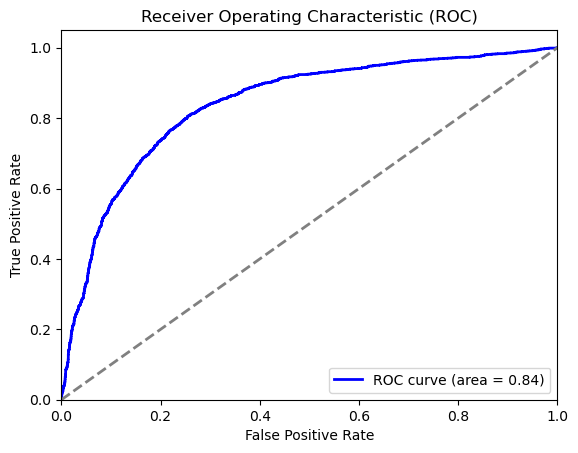

In [41]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [42]:
# 8. Print AUC-ROC score
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.8381104116405184


In [51]:
y_test_probs = classifier.predict_proba(test_data)[:, 1]  # Probabilities for class 1 (positive class)

submission = pd.DataFrame({'index': index, 'target': y_test_probs})
submission.to_csv('submission.csv', index=False)

In [44]:
# Define the Optuna objective function
def objective(trial):
    # Define hyperparameter search space for LightGBM
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
    }

    # Create LightGBM datasets
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_test, label=y_test, reference=dtrain)

    # Train LightGBM model with early stopping
    model = lgb.train(
        param, dtrain, valid_sets=[dvalid]
    )

    # Predict the probabilities on the validation set (X_test)
    y_pred = model.predict(X_test)

    # Calculate the AUC-ROC score
    auc = roc_auc_score(y_test, y_pred)
    
    return auc  # Optuna maximizes this value

# Create an Optuna study object and optimize
study = optuna.create_study(direction='maximize')  # We want to maximize AUC
study.optimize(objective, n_trials=100)  # Run 100 trials

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_trial.params)

[I 2024-11-10 09:36:45,892] A new study created in memory with name: no-name-6c744fc2-5b93-4df7-a1e9-007fb9557e3a
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/1930687912.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/1930687912.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/1930687912.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

Best hyperparameters: {'lambda_l1': 1.3119166714544768, 'lambda_l2': 0.9256007790056319, 'num_leaves': 76, 'feature_fraction': 0.6675314420980336, 'bagging_fraction': 0.9497783601894813, 'bagging_freq': 4, 'min_child_samples': 13, 'learning_rate': 0.06987504497511264}


Best hyperparameters: {'lambda_l1': 1.2357079313770156, 'lambda_l2': 6.655423664612926e-05, 'num_leaves': 107, 'feature_fraction': 0.7661401535089436, 'bagging_fraction': 0.9339865470144761, 'bagging_freq': 6, 'min_child_samples': 64, 'learning_rate': 0.07265053873680105}

In [ ]:
# Define the Optuna objective function
def objective(trial):
    # Define hyperparameter search space for LightGBM
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_bin': trial.suggest_int('max_bin', 64, 512),
    }

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]
        
        # Create LightGBM datasets
        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dvalid = lgb.Dataset(X_valid_cv, label=y_valid_cv, reference=dtrain)

        # Train LightGBM model with early stopping and pruning
        model = lgb.train(
            param, dtrain, valid_sets=[dvalid]
        )
        
        # Predict and calculate AUC for the validation fold
        y_pred = model.predict(X_valid_cv)
        auc = roc_auc_score(y_valid_cv, y_pred)
        auc_scores.append(auc)
    
    # Return the mean AUC across folds
    return np.mean(auc_scores)

# Create an Optuna study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_trial.params)

In [45]:
# Train final model with the best parameters on the entire training dataset
best_params = study.best_trial.params
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'

# Re-train the model using the best hyperparameters on the entire dataset
final_model = lgb.train(best_params, lgb.Dataset(X, label=y))

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


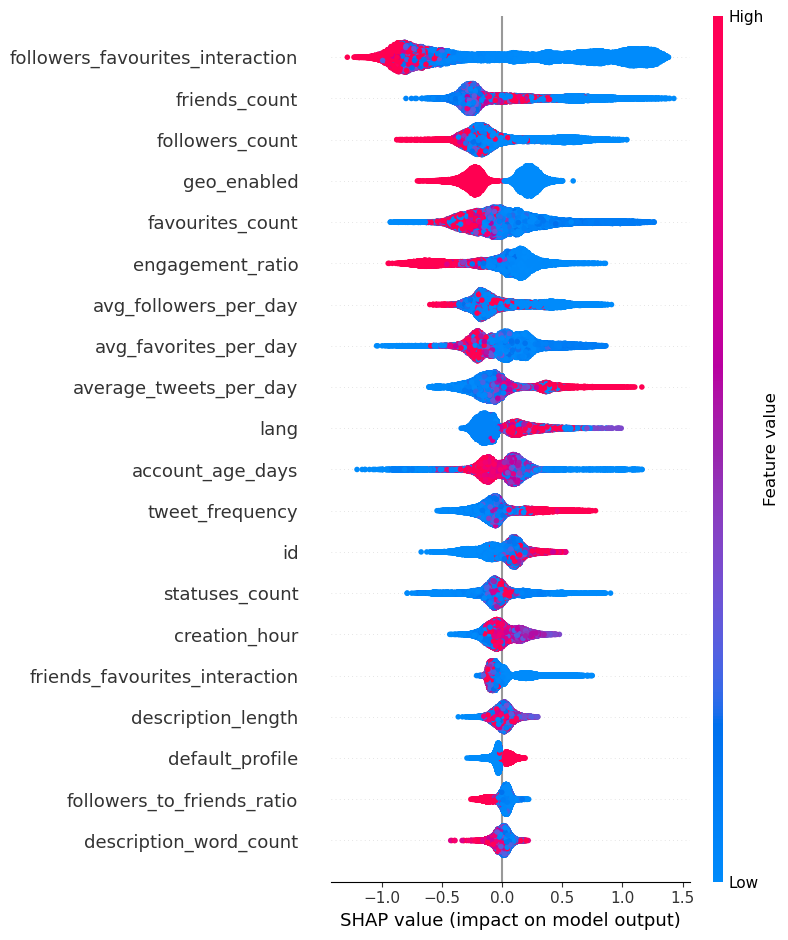

In [46]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


In [47]:
# Generate predictions on the test data (X_test) using the final model
y_test_probs = final_model.predict(X_test)  # Ensure predictions are made on the same X_test

# Calculate the AUC-ROC score on the test data
auc_roc_test = roc_auc_score(y_test, y_test_probs)
print("AUC-ROC Score on Test Data:", auc_roc_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

AUC-ROC Score on Test Data: 0.9734049355358781


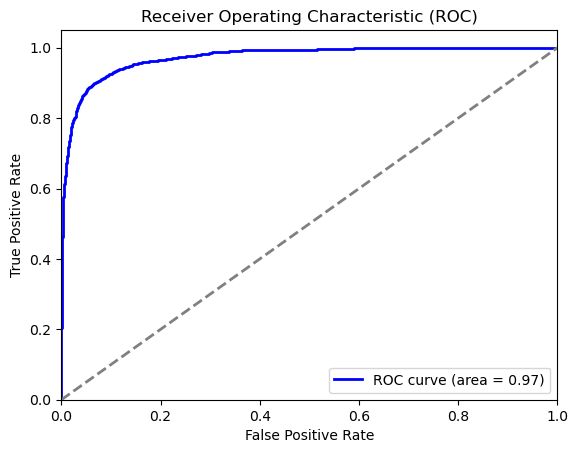

In [48]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [52]:
y_test_probs = final_model.predict(test_data)  # Probabilities for class 1 (positive class)

submission = pd.DataFrame({'index': index, 'target': y_test_probs})
submission.to_csv('submission_lgb5.csv', index=False)

In [53]:
# Define the Optuna objective function for XGBoost
def objective(trial):
    # Define the hyperparameter search space for XGBoost
    param = {
        'objective': 'binary:logistic',  # Binary classification
        'eval_metric': 'auc',            # AUC as evaluation metric
        'tree_method': 'auto',           # Use auto tree method
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
    }

    # Create DMatrix objects for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    # Train the XGBoost model with the current set of hyperparameters
    model = xgb.train(
        param, dtrain, evals=[(dvalid, 'validation')], 
        early_stopping_rounds=50, verbose_eval=False
    )

    # Predict the probabilities on the validation set
    y_pred = model.predict(dvalid)

    # Calculate the AUC-ROC score
    auc = roc_auc_score(y_test, y_pred)
    
    return auc  # Optuna will maximize this value

# Create an Optuna study object and optimize
study = optuna.create_study(direction='maximize')  # We want to maximize AUC
study.optimize(objective, n_trials=100)  # Run 100 trials

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_trial.params)

[I 2024-11-10 09:40:50,171] A new study created in memory with name: no-name-60c3587c-a27e-49c6-8a07-98ec2795c3d6
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/593071393.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/593071393.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/593071393.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

Best hyperparameters: {'lambda': 6.738422580101414e-08, 'alpha': 4.523719744229541e-08, 'colsample_bytree': 0.562014200980714, 'subsample': 0.9728302373286251, 'learning_rate': 0.07830108858105254, 'n_estimators': 481, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 0.002982764715928884}


In [ ]:
best_lgb_params = {'lambda': 0.005470066005739702, 'alpha': 5.530064421764076e-08, 'colsample_bytree': 0.6686801683547646, 'subsample': 0.966205414212702, 'learning_rate': 0.0329209473825285, 'n_estimators': 319, 'max_depth': 13, 'min_child_weight': 3, 'gamma': 1.8996116586378517e-08}


In [54]:
# Train final model with the best hyperparameters on the full training data
best_params = study.best_trial.params
dtrain_full = xgb.DMatrix(X, label=y)

# Train the final XGBoost model on the entire dataset
final_model = xgb.train(best_params, dtrain_full)

# Generate predictions on the validation data (X_test)
dtest = xgb.DMatrix(X_test)
y_test_probs = final_model.predict(dtest)

# Calculate the AUC-ROC score on the validation set
auc_roc_test = roc_auc_score(y_test, y_test_probs)
print(f"AUC-ROC Score on Validation Data: {auc_roc_test:.4f}")

AUC-ROC Score on Validation Data: 0.9888


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:41:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


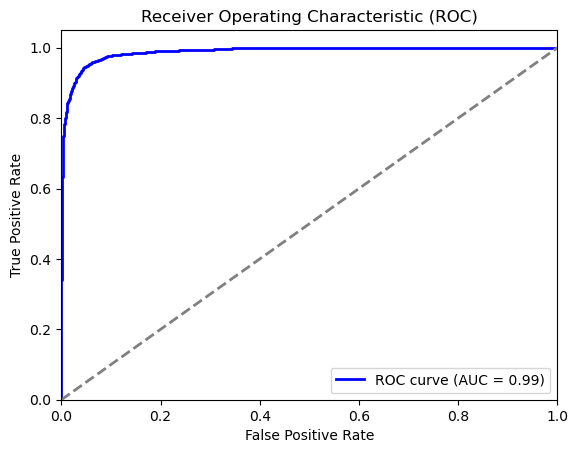

In [55]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_roc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [56]:
# Predict on the actual test data
dtest_final = xgb.DMatrix(test_data)  # Assuming test_data is preprocessed
y_test_probs_final = final_model.predict(dtest_final)

# Create the submission DataFrame
submission = pd.DataFrame({'index': test_data.index, 'target': y_test_probs_final})

# Save to CSV for submission
submission.to_csv('submission_xgboost2.csv', index=False)

In [57]:
# Define the Optuna objective function for XGBoost with DART booster
def objective(trial):
    # Define the hyperparameter search space for XGBoost with DART
    param = {
        'objective': 'binary:logistic',   # Binary classification
        'eval_metric': 'auc',             # AUC as evaluation metric
        'booster': 'dart',                # Use DART booster
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        # DART specific parameters
        'sample_type': trial.suggest_categorical('sample_type', ['uniform', 'weighted']),
        'normalize_type': trial.suggest_categorical('normalize_type', ['tree', 'forest']),
        'rate_drop': trial.suggest_uniform('rate_drop', 0.0, 0.5),
        'skip_drop': trial.suggest_uniform('skip_drop', 0.0, 0.5),
    }

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    # Train the XGBoost model with DART
    model = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], 
                      early_stopping_rounds=50, verbose_eval=False)

    # Predict probabilities on the validation set
    y_pred = model.predict(dvalid)

    # Calculate the AUC-ROC score
    auc = roc_auc_score(y_test, y_pred)
    
    return auc  # Optuna will maximize this value

# Create an Optuna study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_trial.params)

[I 2024-11-10 09:41:17,320] A new study created in memory with name: no-name-2226f654-a5a1-4c87-a750-5504cbeb7fad
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/3072703703.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/3072703703.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
/var/folders/5k/zv5thkbd1cvg39zpcv0jgt400000gn/T/ipykernel_2029/3072703703.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

Best hyperparameters: {'lambda': 9.827942623864836e-08, 'alpha': 1.8082026893430664e-07, 'colsample_bytree': 0.8199101953304343, 'subsample': 0.7274406614245961, 'learning_rate': 0.05664242645285094, 'n_estimators': 571, 'max_depth': 13, 'min_child_weight': 3, 'gamma': 8.934503133197543e-07, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.2889162225574469, 'skip_drop': 0.46647360192603254}


In [ ]:
best_xgb_params =  {'lambda': 0.0004290836238071964, 'alpha': 4.5245386883338946e-08, 'colsample_bytree': 0.7246400846815281, 'subsample': 0.9372544242294605, 'learning_rate': 0.05295575381861641, 'n_estimators': 680, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 2.90549925394814e-06, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.07640643484631213, 'skip_drop': 0.45406424387807504}

In [58]:
# Train the final model with the best DART hyperparameters
best_params = study.best_trial.params
dtrain_full = xgb.DMatrix(X, label=y)

# Train the final XGBoost model using DART on the entire dataset
final_model = xgb.train(best_params, dtrain_full)

# Generate predictions on the validation data (X_test)
dtest = xgb.DMatrix(X_test)
y_test_probs = final_model.predict(dtest)

# Calculate the AUC-ROC score on the validation set
auc_roc_test = roc_auc_score(y_test, y_test_probs)
print(f"AUC-ROC Score on Validation Data: {auc_roc_test:.4f}")

AUC-ROC Score on Validation Data: 0.9937


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:41:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "n_estimators", "normalize_type", "rate_drop", "sample_type", "skip_drop" } are not used.

  warnings.warn(smsg, UserWarning)


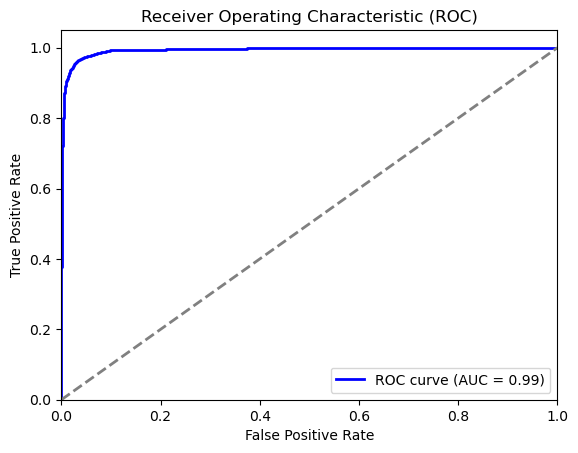

In [59]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_roc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Predict on the actual test data
dtest_final = xgb.DMatrix(test_data)  # Assuming test_data is preprocessed
y_test_probs_final = final_model.predict(dtest_final)

# Create the submission DataFrame
submission = pd.DataFrame({'index': test_data.index, 'target': y_test_probs_final})

# Save to CSV for submission
submission.to_csv('submission_xgboost_dart2.csv', index=False)

In [ ]:
# Step 2: Train the base models
# XGBoost
dtrain_xgb = xgb.DMatrix(X_train, label=y_train)
xgb_params = best_xgb_params  # Use the best XGBoost parameters from Optuna or previous tuning
xgb_model = xgb.train(xgb_params, dtrain_xgb)

# LightGBM
dtrain_lgb = lgb.Dataset(X_train, label=y_train)
lgb_params = best_lgb_params  # Use the best LightGBM parameters from Optuna or previous tuning
lgb_model = lgb.train(lgb_params, dtrain_lgb)

# RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 3: Generate meta-features (predictions from base models on training set)
xgb_train_pred = xgb_model.predict(xgb.DMatrix(X_train))  # XGBoost predictions
lgb_train_pred = lgb_model.predict(X_train)  # LightGBM predictions
rf_train_pred = rf_model.predict_proba(X_train)[:, 1]  # RandomForest predictions (probabilities for class 1)

# Stack the predictions as new features (meta-features)
meta_features_train = np.column_stack((xgb_train_pred, lgb_train_pred, rf_train_pred))

# Step 4: Train the meta-model (Logistic Regression) on the stacked predictions
meta_model = LogisticRegression()
meta_model.fit(meta_features_train, y_train)

# Step 5: Generate predictions for the validation set (X_test) using base models
xgb_test_pred = xgb_model.predict(xgb.DMatrix(X_test))  # XGBoost test predictions
lgb_test_pred = lgb_model.predict(X_test)  # LightGBM test predictions
rf_test_pred = rf_model.predict_proba(X_test)[:, 1]  # RandomForest test predictions (probabilities for class 1)

# Stack predictions for the validation set (meta-features for X_test)
meta_features_test = np.column_stack((xgb_test_pred, lgb_test_pred, rf_test_pred))

# Step 6: Final prediction on the validation set using the meta-model
meta_test_pred = meta_model.predict_proba(meta_features_test)[:, 1]  # Get probability for class 1

# Step 7: Evaluate the AUC-ROC score on the validation set
auc_roc_test = roc_auc_score(y_test, meta_test_pred)
print(f"AUC-ROC Score (Stacked Model): {auc_roc_test:.4f}")

In [ ]:
# Step 8: Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, meta_test_pred)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_roc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Stacked Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Step 9: Predict on the actual test data for final submission
# Assuming test_data is your new test dataset (preprocessed)
dtest = xgb.DMatrix(test_data)  # XGBoost test data
xgb_test_final = xgb_model.predict(dtest)
lgb_test_final = lgb_model.predict(test_data)
rf_test_final = rf_model.predict_proba(test_data)[:, 1]

# Stack predictions for final test data
meta_features_final = np.column_stack((xgb_test_final, lgb_test_final, rf_test_final))

# Final predictions using the meta-model
meta_test_final_pred = meta_model.predict_proba(meta_features_final)[:, 1]

# Step 10: Save the final predictions for submission
submission = pd.DataFrame({'index': test_data.index, 'target': meta_test_final_pred})
submission.to_csv('submission_stacked_model2.csv', index=False)

In [ ]:
# Train XGBoost as the meta-model
meta_model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')
meta_model_xgb.fit(meta_features_train, y_train)

# Predict on test set using the XGBoost meta-model
meta_test_pred = meta_model_xgb.predict_proba(meta_features_test)[:, 1]

# Evaluate AUC-ROC
auc_roc_test = roc_auc_score(y_test, meta_test_pred)
print(f"AUC-ROC Score (XGBoost Meta-Model): {auc_roc_test:.4f}")